(unsupervised:centroid-clustering)=
# Centroid-based Clustering (k-Means)

Centroid-based clustering algorithms represent clusters by single points in the data space (center points, mostly the clusters' centroids). Corresponding clusters then are given by some distance condition. All points closer to some center point than to all others belong to one cluster, for instance. Consequently, centroid-based methods yield sphere-shaped clusters with concrete shape depending on the chosen distance measure.

The major centroid-based clustering method is $k$-means. Others, not discussed here, are [$k$-medians](https://en.wikipedia.org/wiki/K-medians_clustering) and [$k$-medoids](https://en.wikipedia.org/wiki/K-medoids).

Related projects:
* [](projects:mnist)
  * [](projects:mnist:semisupervised-classification)
* [](projects:supermarket-customers)

## $k$-Means Idea

Clusters obtained from $k$-means method are determined by center points. Given $k$ points $u_1,\ldots,u_k$ in $\mathbb{R^m}$ (the centers) corresponding clusters are defined by
\begin{equation*}
C(u_l):=\bigl\{x\in\{x_1,\ldots,x_n\}:\,d(x,u_l)\leq d(x,u_\lambda)\text{ for all }\lambda\neq l\bigr\}.
\end{equation*}
A cluster contains all samples which are closer to the cluster's center than to other clusters' centers. In case of equality a sample formally belongs to two or more clusters. In practice, a cluster is chosen by chance to obtain mutually disjoint clusters.

A prescribed clustering (collection of subsets of our data set) may or may not have a set of center points, that is, a set such that for each point in the set all points in the corresponding cluster are closer to that point than to any other cluster's center (simple example: one cluster belongs to the convex hull of another cluster).

Although $k$-means is closely related to centroids (see below), a cluster's centroid not necessarily is a center point.

```{figure} centroids-centers.svg
---
alt: center points versus centroids
---
Centroids not necessarily are center points.
```

The $k$-means method aims at minimizing the average distance of samples to the closest cluster center. The number $k$ of clusters has to be provided in advance. The outcome are the cluster centers.

In formulas, we want to minimize the function
\begin{equation*}
(u_1,\ldots,u_k)\mapsto\frac{1}{n}\,\sum_{l=1}^k\sum_{x\in C(u_l)} d(x,u_l)
\end{equation*}
with respect to all possible cluster centers $\{u_1,\ldots,u_k\}$. The distance measure $d$ almost always is the squared Euclidean distance.

Finding optimal cluster centers is closely related to finding optimal locations for warehouses, hospitals, fire stations, and so on (see [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)).

## Naive $k$-Means Algorithm

Naive $k$-means algorithm (also known as Lloyd's algorithm) starts with a set of initial center points $u_1,\ldots,u_k$ and repeats the following two steps:
* Build clusters $C(u_1),\ldots,C(u_k)$ for current centers $u_1,\ldots,u_k$.
* Update $u_1,\ldots,u_k$ to be the centroids of the current clusters.

Iteration is stopped if clusters do not change anymore. One can show that this method always converges (that is, stops) and that the resulting center points are a local (not a global!) minimizer of the above objective function. From the stopping criterion we immediately see, that centers computed by naive $k$-means always are centroids of their clusters.

The described algorithm takes two parameters:
* the number $k$ of clusters to find,
* initial center points $u_1,\ldots,u_k$ defining the initial clustering.

There exist several methods to choose these parameters. In some cases $k$ can be obtained from domain knowledge. Else $k$ has to be obtained from typical hyperparameter optimization techniques. Center points may be initialized randomly or by some specialized initialization routines (see below).

## Implementation from Scratch

Before we have a closer look at different methods for choosing $k$ and initial centers we implement naive $k$-means from scratch. Later we will use Scikit-Learn's implementation.

First we create some synthetic data to be clustered.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

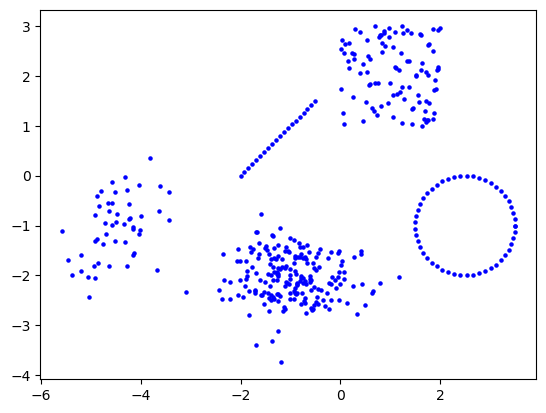

In [2]:
# 5 clusters in 2 dimensions

n1, n2, n3, n4, n5 = 100, 200, 20, 50, 50
n = n1 + n2 + n3 + n4 + n5

X1 = rng.uniform((0, 1), (2, 3), (n1, 2))
X2 = rng.multivariate_normal((-1, -2), ((0.5, 0), (0, 0.2)), n2)
X3 = np.linspace(-1, 0.5, n3).reshape(-1, 1) * np.ones((1, 2)) + np.array([[-1, 1]])
X4 = rng.multivariate_normal((-4.5, -1), ((0.2, 0.1), (0.1, 0.4)), n4)
phi = np.linspace(0, 2 * np.pi, n5).reshape(-1, 1)
X5 = np.array([[2.5, -1]]) + np.concatenate((np.cos(phi), np.sin(phi)), axis=1)

X = np.concatenate((X1, X2, X3, X4, X5))

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c='b')
ax.axis('equal')
plt.show()

$k$-means takes the number of clusters `k` and initial centers `init_centers` as parameters. Iteration is stopped if current and previous clustering coincide. To prevent too many iteration we also set a maximum number of iterations `max_iter`.

Center points will be stored rowwise in NumPy arrays (like for the samples in `X`). In each iteration we have to calculate all distances between samples and center points. Those distances will be stored in an `(n, k)` NumPy array `dists`. A clustering will be represented by a 1d NumPy array `clusters` of length `n` containing for each sample the index of the closest center point. When updating the centers we have to keep the old centers to check the stopping criterion. After each $k$-means step we plot the intermediate result.

+ is current centroid
x is previous centroid
empty cluster


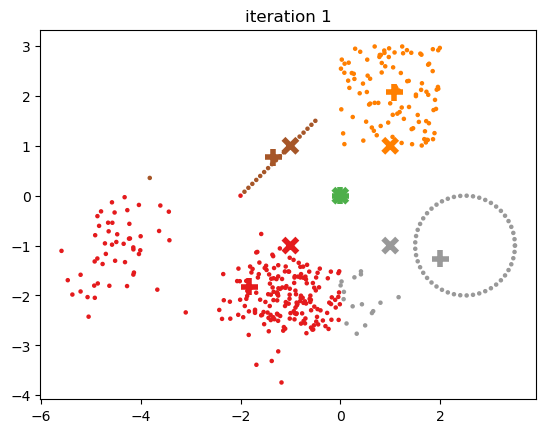

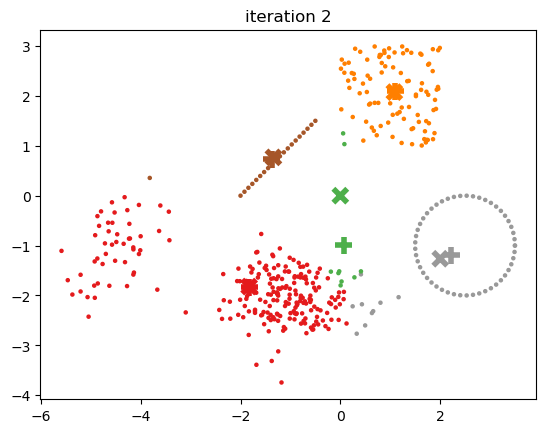

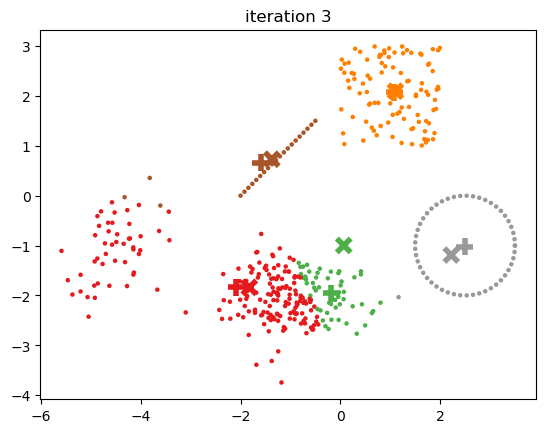

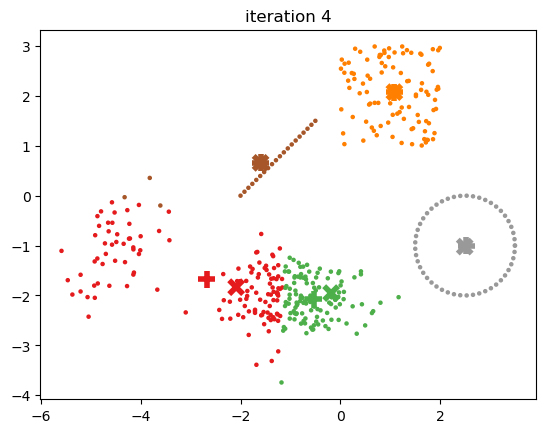

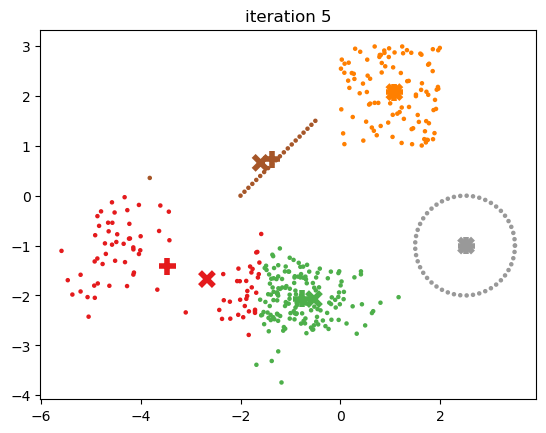

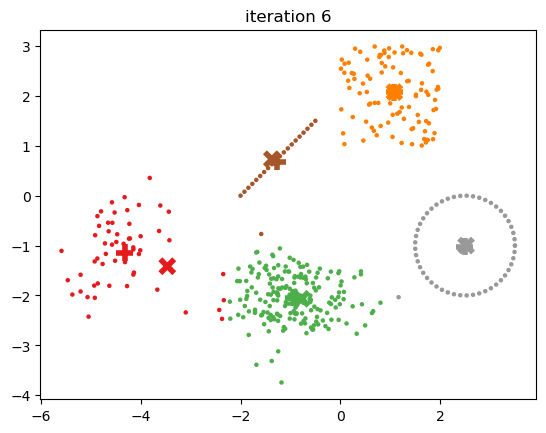

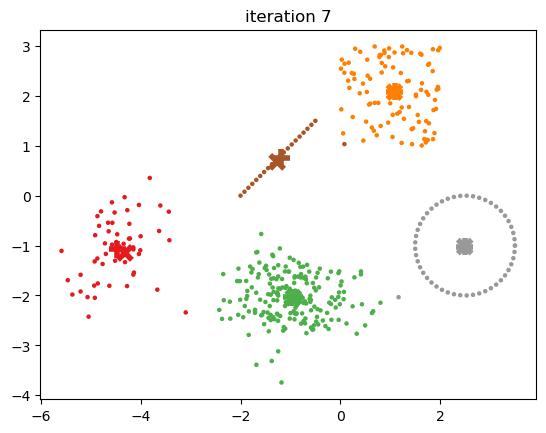

stopping criterion satisfied after 7 iterations


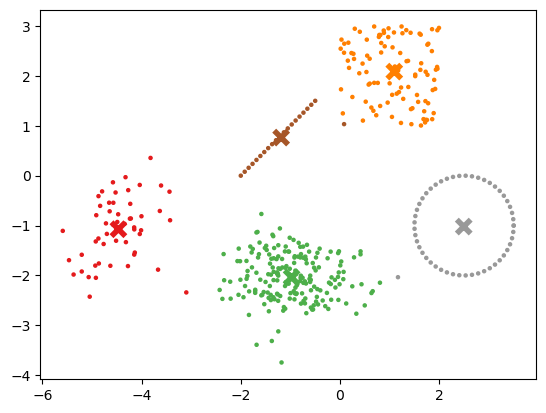

In [3]:
k = 5
init_centers = np.array([[-1, -1], [0, 0], [1, 1], [-1, 1], [1, -1]], dtype=float)
#k = 4
#init_centers = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]], dtype=float)
#k = 3
#init_centers = np.array([[-1, -1], [-1, 1], [1, -1]], dtype=float)
#k = 6
#init_centers = np.array([[-1, -1], [0, 0], [1, 1], [-1, 1], [1, -1], [0.5, 0.5]], dtype=float)
#k = 7
#init_centers = np.array([[-1, -1], [0, 0], [1, 1], [-1, 1], [1, -1], [0.5, 0.5], [-0.5, -0.5]], dtype=float)

max_iter = 20

print('+ is current centroid')
print('x is previous centroid')

centers = init_centers
for i in range(0, max_iter):

    fig, ax = plt.subplots()
    
    # get clusters
    if i > 0:
        old_clusters = clusters
    dists = np.empty((n, k))
    for l in range(0, k):
        dists[:, l] = np.sum((X - centers[l, :]) ** 2, axis=1)
    clusters = dists.argmin(axis=1)
    
    # plot clusters and centers
    ax.scatter(X[:, 0], X[:, 1], s=5, c=clusters, cmap='Set1')
    ax.scatter(centers[:, 0], centers[:, 1], s=100, c=range(0, k), cmap='Set1', marker='x', linewidth=4)

    # update centers
    old_centers = centers.copy()
    for l in range(0, k):
        if np.any(clusters == l):    # update only if cluster is not empty
            centers[l, :] = X[clusters == l, :].mean(axis=0)
        else:
            print('empty cluster')
    
    # stopping criterion
    if i > 0 and (old_clusters == clusters).all():
        print('stopping criterion satisfied after {} iterations'.format(i))
        break

    # plot new centers
    ax.scatter(centers[:, 0], centers[:, 1], s=150, c=range(0, k), cmap='Set1', marker='+', linewidth=4)
    
    ax.set_title('iteration ' + str(i + 1))
    ax.axis('equal')
    
    plt.show()
    
else:
    print('max_iter reached')

## Implementation with Scikit-Learn

Scikit-Learn implements a [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class in its `cluster` module. The `fit` method generates the clustering, resulting in a list of cluster centers. The `predict` method assigns cluster labels to samples.
Note that `fit` already computes labels for training data. So we do not have to call `predict` on training data.

The `KMeans` constructor takes several arguments described in the documentation. Values for the `init` parameter will be described below. In case of random initialization `n_init` is the number of $k$-means runs. From multiple runs Scikit-Learn chooses the result with lowest inertia, that is, with smallest sum of squared distances of samples to their closest cluster center. Next to naive $k$-means Scikit-Learn supports the (often) more efficient Elkan method, which uses the triangle inequality to avoid unnecessary distance calculations.

In [4]:
import sklearn.cluster as cluster

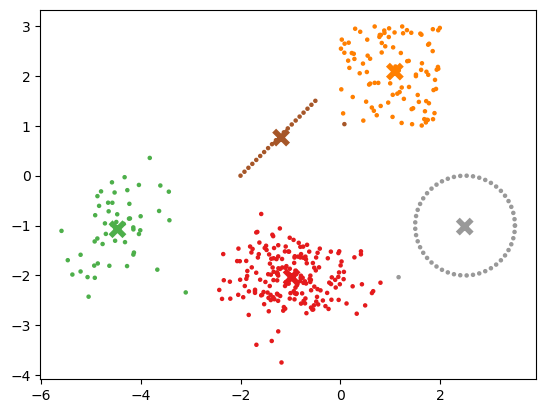

In [5]:
k = 5
init_centers = np.array([[-1, -1], [0, 0], [1, 1], [-1, 1], [1, -1]], dtype=float)

km = cluster.KMeans(n_clusters=k, init=init_centers, n_init=1)
km.fit(X)
centers = km.cluster_centers_
clusters = km.labels_

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=clusters, cmap='Set1')
ax.scatter(centers[:, 0], centers[:, 1], s=100, c=range(0, k), cmap='Set1', marker='x', linewidth=4)
ax.axis('equal')
plt.show()

## Random Initialization

There exist (at least) two approaches for randomly choosing initial cluster centers:
* Choosing $k$ random samples from the training data.
* Randomly assign samples to $k$ clusters and take the centroids as initial centers.

The second approach results in closely spaced initial centers, whereas the first yields initial centers scattered over the data set. Scikit-Learn only implements the first approach, which can be activated with `init='random'`.

If we use random initialization the `n_init` parameter should be greater than one (defaults to 10). Scikit-Learn will run the algorithm `n_init` times and choose the best result (lowest inertia).

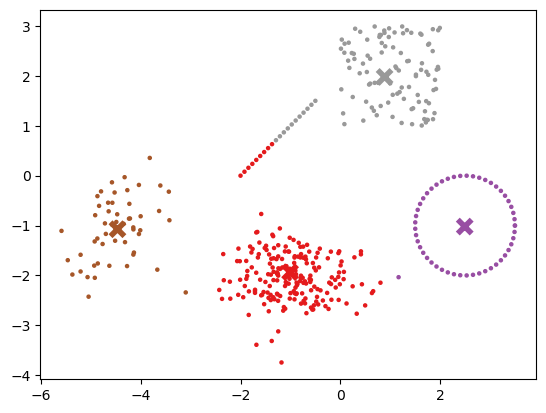

In [6]:
k = 4

km = cluster.KMeans(n_clusters=k, init='random', n_init=10)
km.fit(X)
centers = km.cluster_centers_
clusters = km.labels_

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=clusters, cmap='Set1')
ax.scatter(centers[:, 0], centers[:, 1], s=100, c=range(0, k), cmap='Set1', marker='x', linewidth=4)
ax.axis('equal')
plt.show()

## $k$-Means++ for Initializing Centers

$k$-means++ is not an improved variant of $k$-means, but an algorithm for choosing good initial cluster centers for $k$-means. Here 'good' means fast convergence of $k$-means based on the initial centers.

$k$-means++ chooses all initial centers randomly from the training data set (like random initialization), but only the first center is chosen uniformly at random.
After the first center has been chosen the following procedure is repeated until $k$ centers have been found:
* For each sample (except the ones already chosen as center point) calculate the distance to the closest center.
* Choose a sample as next center point at random with probabilities proportional to the squared distances.

Samples far away from already existing center points are more likely to become the next center. Thus, initial centers chosen by $k$-means++ will be scattered over the whole data set and closely spaced centers are very unlikely.

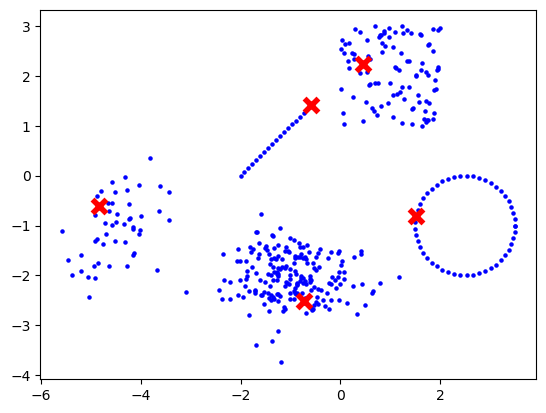

In [7]:
k = 5

init_centers = np.empty((k, X.shape[1]))

# first center uniformly at random
init_centers[0, :] = X[rng.integers(0, X.shape[0]), :]

for l in range(1, k):
    
    # calculate distances to closest center (l centers already exist)
    dists = np.empty((n, l))
    for j in range(0, l):
        dists[:, j] = np.sum((X - init_centers[j, :]) ** 2, axis=1)
    min_dists = dists.min(axis=1)
    
    # next center with probability proportional to distance to closest center
    init_centers[l, :] = rng.choice(X, 1, p=min_dists/min_dists.sum())
    
# plot
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c='b')
ax.scatter(init_centers[:, 0], init_centers[:, 1], s=100, c='r', marker='x', linewidth=4)
ax.axis('equal')
plt.show()

## Choosing $k$

$k$-means aims to minimize the sum of distances of all samples to the closest cluster center. Thus, a suitable $k$ should yield small objective function. Obviously $k=n$ with each sample being a cluster center would be the best choice, but this is not our intention when clustering data. Instead we want to have a sensible number of clusters.

Starting with $k=2$ we may run $k$-means for an increasing sequence of values for $k$. The more clusters we allow, the smaller the objective in the above minimization problem. If $k$ becomes larger than the number of clusters in the data, then the drop in the objective will be much smaller than for smaller $k$. If we plot the objective values against the number of clusters we should see an elbow-like curve. The $k$ at the elbow should be chosen. This heuristic approach is known as *Elbow method*. Often it works quite well, but especially in case of clusters not well separated the elbow may be hard to identify. Another drawback is, that reliable automatic detection of the elbow's position is difficult.

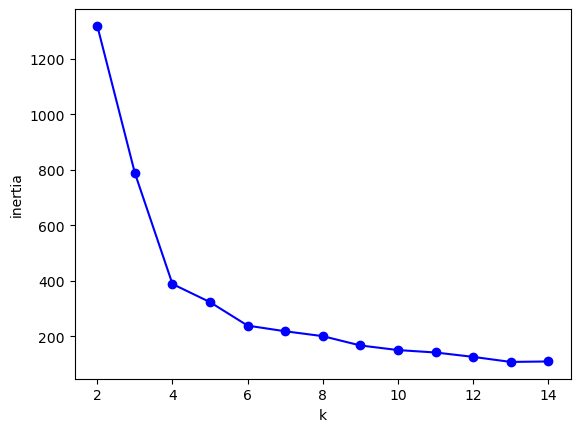

In [8]:
ks = range(2, 15)

obj_values = []
for k in ks:
    km = cluster.KMeans(n_clusters=k, n_init='auto')
    km.fit(X)
    obj_values.append(km.inertia_)

fig, ax = plt.subplots()
ax.plot(ks, obj_values, '-ob')
ax.set_xlabel('k')
ax.set_ylabel('inertia')
plt.show()

The elbow method here suggests $k=4$.

An alternative to the elbow method is to consider quality measures for clusterings for different $k$. Scikit-Learn provides implementations for the silhouette score ([`silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)) and for the Davies-Bouldin index ([`davies_bouldin_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)) and for [many other clustering metrics](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics).

In [9]:
import sklearn.metrics as metrics

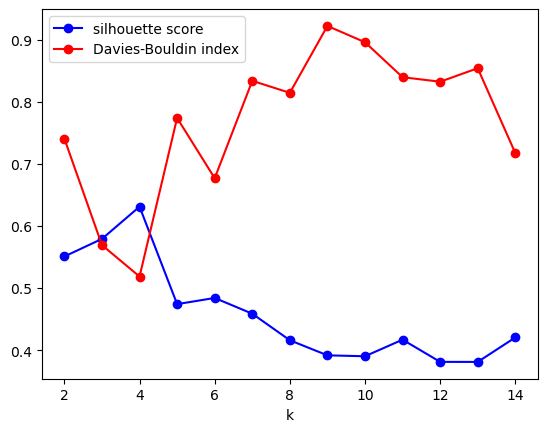

In [10]:
ks = range(2, 15)

sil = []
db = []
for k in ks:
    km = cluster.KMeans(n_clusters=k, n_init='auto')
    km.fit(X)
    sil.append(metrics.silhouette_score(X, km.labels_))
    db.append(metrics.davies_bouldin_score(X, km.labels_))

fig, ax = plt.subplots()
ax.plot(ks, sil, '-ob', label='silhouette score')
ax.plot(ks, db, '-or', label='Davies-Bouldin index')
ax.set_xlabel('k')
ax.legend()
plt.show()

Both scores suggest $k=4$.

## Per Sample Silhouette Score

To judge on the quality of a clustering we may also look at each sample's silhouette score. This way we can identify missclusterings or samples with uncertain cluster assignment. Scikit-Learn provides [`silhouette_samples`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) for this purpose.

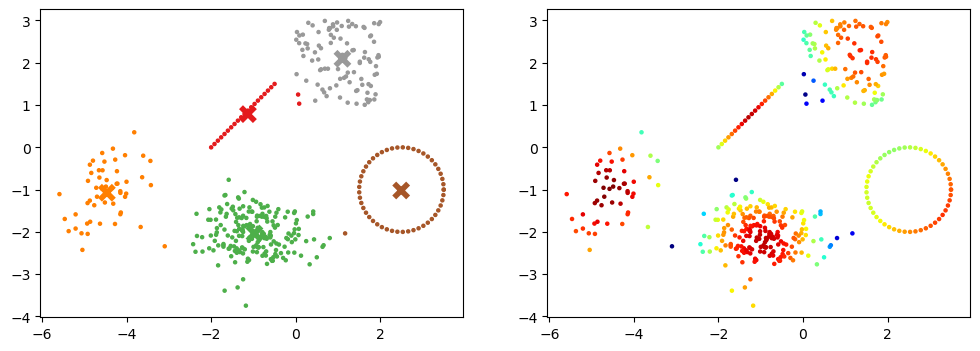

In [11]:
k = 5

km = cluster.KMeans(n_clusters=k, n_init='auto')
km.fit(X)
centers = km.cluster_centers_
clusters = km.labels_
sil = metrics.silhouette_samples(X, km.labels_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(X[:, 0], X[:, 1], s=5, c=clusters, cmap='Set1')
ax1.scatter(centers[:, 0], centers[:, 1], s=100, c=range(0, k), cmap='Set1', marker='x', linewidth=4)
ax1.axis('equal')
ax2.scatter(X[:, 0], X[:, 1], s=5, c=sil, cmap='jet')
ax2.axis('equal')
plt.show()

Red points (high silhouette score) clearly belong to their cluster, blue points (low silhouette score) also could belong to a different or to no cluster.

## $k$-Means for Very Large Data Sets

$k$-means requires as many distance computations per cluster and per iteration as there are samples in the training data set. To reduce computation time for large data sets we may
* use only a subset of the training data in each iteration (subsets change from iteration to iteration) and
* update center points sample by sample instead of cluster by cluster.

Working with subsets obviously reduces the amount of distance calculations. Depending on the randomly chosen subsets, cluster centers may change very much from iteration to iteration. To prevent such hopping, updates are calculated sample by sample, resulting in slightly different update results. A side effect of the sample-by-sample approach is a more efficient implementation of the update step. Details are given in [Web-Scale K-Means Clustering](https://web.archive.org/web/20230210073106/https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf).

Scikit-Learn implements this approach as [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

## When to Use $k$-Means?

$k$-means is very fast (at least faster than most other clustering algorithms). But it has some drawbacks one has to be aware of.

For very high dimensional data (thousands of features, images for instance) distances between samples do not carry useful information because all distances are almost identical (cf. discussion of curse of dimensionality in [](supervised:general:example-knn)). Thus, $k$-means wont work. Resulting clusters will look like samples were assigned to clusters uniformly at random. Dimension reduction techniques (e.g. PCA) should be applied before trying $k$-means.

$k$-means prefers convex and sphere shaped clusters. Proper scaling of the data may improve results drastically, especially if features have very different numerical ranges. Alternatively the used distance measure has to be adapted to the data under consideration (weighted Euclidean distance, for instance).

In [12]:
n1, n2, n3 = 1000, 1000, 1000
n = n1 + n2 + n3

X1 = rng.multivariate_normal((0, -2), ((2, 0), (0, 0.02)), n1)
X2 = rng.multivariate_normal((0, 0), ((2, 0), (0, 0.02)), n2)
X3 = rng.multivariate_normal((0, 2), ((2, 0), (0, 0.02)), n3)

X = np.concatenate((X1, X2, X3))

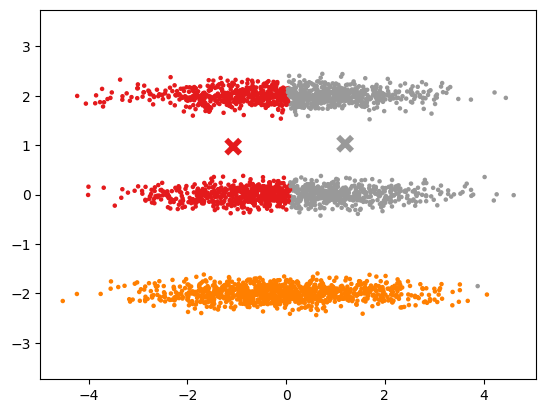

In [13]:
k = 3

km = cluster.KMeans(n_clusters=k, n_init='auto')
km.fit(X)
centers = km.cluster_centers_
clusters = km.labels_

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=clusters, cmap='Set1')
ax.scatter(centers[:, 0], centers[:, 1], s=100, c=range(0, k), cmap='Set1', marker='x', linewidth=4)
ax.axis('equal')
plt.show()

Due to its distance-to-center based nature $k$-means prefers clusters with similar spatial extent.

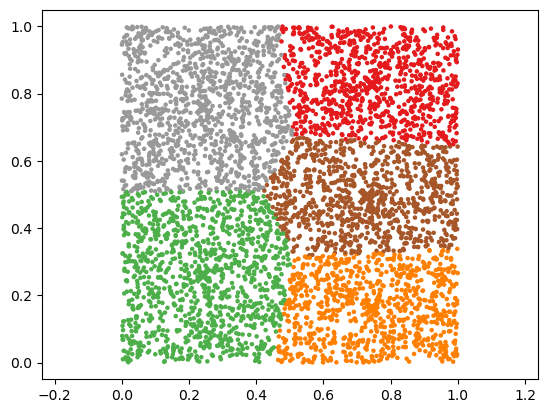

In [14]:
n = 5000
X = rng.uniform((0, 0), (1, 1), (n, 2))

k = 5

km = cluster.KMeans(n_clusters=k, n_init='auto')
km.fit(X)
centers = km.cluster_centers_
clusters = km.labels_

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=clusters, cmap='Set1')
ax.scatter(centers[:, 0], centers[:, 1], s=100, c=range(0, k), cmap='Set1', marker='x', linewidth=4)
ax.axis('equal')
plt.show()